In [1]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


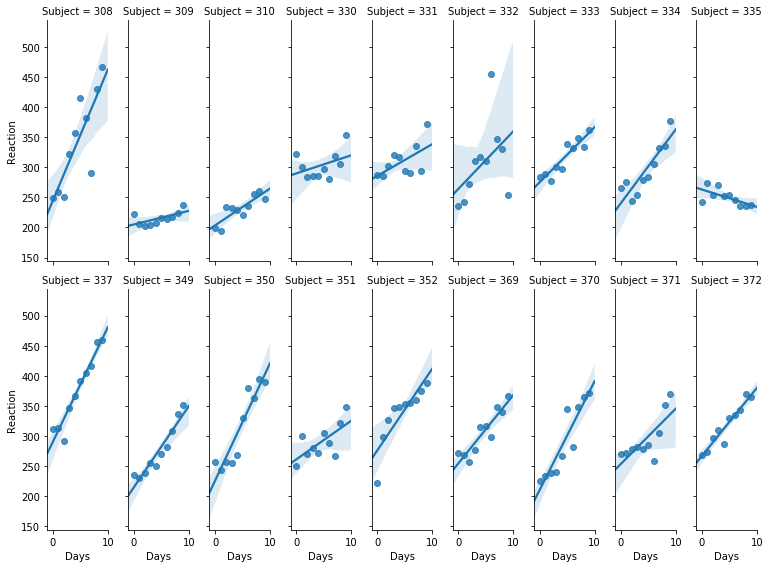

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:15, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [5]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [6]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [8]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [9]:
Y = np.asarray(sleep['Reaction'])

In [10]:
with pm.Model() as model:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    gamma_Z = pm.Deterministic('gamma_Z', tt.stack(gamma_Z_intercept, gamma_Z_slope))
    tt.printing.Print('gamma_Z')(gamma_Z)
    
    #correlation_matrix = pm.Deterministic('correlation_matrix', np.corrcoef(gamma_Z))
    #tt.printing.Print('correlation_matrix')(correlation_matrix)

    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

gamma_Z __str__ = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_slope_raw, scaler_slope_log__, gamma_Z_intercept_raw, scaler_intercept_log__, beta_X_slope, beta_X_intercept_log__]


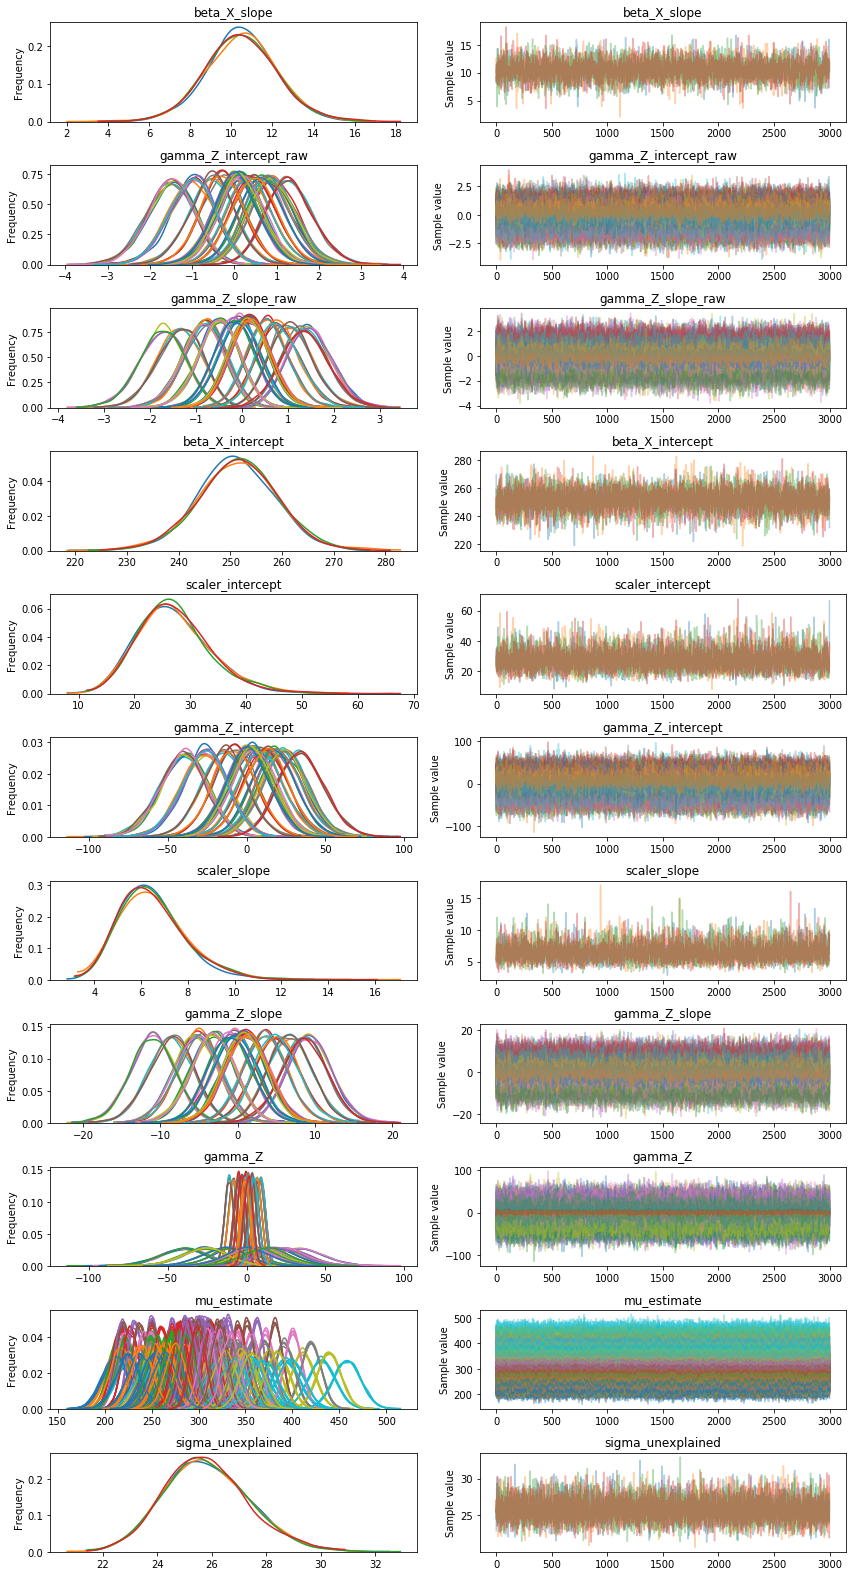

In [11]:
_ = pm.traceplot(trace)

In [12]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.488855,1.707259,0.023594,6.948515,13.782099,4766.747455,0.999881
gamma_Z_intercept_raw__0,0.046696,0.536581,0.004499,-0.998582,1.110146,11829.051039,1.000224
gamma_Z_intercept_raw__1,-1.536890,0.566384,0.005062,-2.668894,-0.459167,10365.734411,0.999874
gamma_Z_intercept_raw__2,-1.483976,0.561949,0.004342,-2.631333,-0.435197,11401.005292,0.999937
gamma_Z_intercept_raw__3,0.942273,0.550145,0.004949,-0.097292,2.065375,11766.975677,0.999869
gamma_Z_intercept_raw__4,0.878275,0.538854,0.004654,-0.129380,1.997740,11787.098208,0.999963
gamma_Z_intercept_raw__5,0.347345,0.540453,0.004454,-0.693516,1.429925,12256.986388,0.999942
gamma_Z_intercept_raw__6,0.652512,0.537802,0.005087,-0.380195,1.718629,11566.534971,0.999947
gamma_Z_intercept_raw__7,-0.283360,0.522320,0.005011,-1.335439,0.728091,12701.856340,0.999974
gamma_Z_intercept_raw__8,0.036335,0.532364,0.004364,-0.976857,1.122049,11943.404256,1.000018


In [13]:
#pm.plot_posterior(trace);

In [14]:
gamma_Z = trace['gamma_Z']
gamma_Z.shape

(12000, 2, 18)

In [15]:
rho = []

for i in gamma_Z:
    rho.append(np.corrcoef(i)[0, 1])

In [16]:
trace.add_values({'rho':np.asarray(rho)})

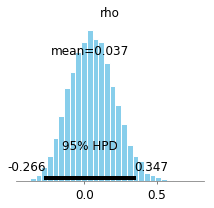

In [25]:
pm.plot_posterior(trace, varnames=['rho'], figsize=(3, 3))

In [18]:
trace_df = pm.trace_to_dataframe(trace)

In [19]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

xvars

['gamma_Z_intercept__0',
 'gamma_Z_intercept__1',
 'gamma_Z_intercept__2',
 'gamma_Z_intercept__3',
 'gamma_Z_intercept__4',
 'gamma_Z_intercept__5',
 'gamma_Z_intercept__6',
 'gamma_Z_intercept__7',
 'gamma_Z_intercept__8',
 'gamma_Z_intercept__9',
 'gamma_Z_intercept__10',
 'gamma_Z_intercept__11',
 'gamma_Z_intercept__12',
 'gamma_Z_intercept__13',
 'gamma_Z_intercept__14',
 'gamma_Z_intercept__15',
 'gamma_Z_intercept__16',
 'gamma_Z_intercept__17']

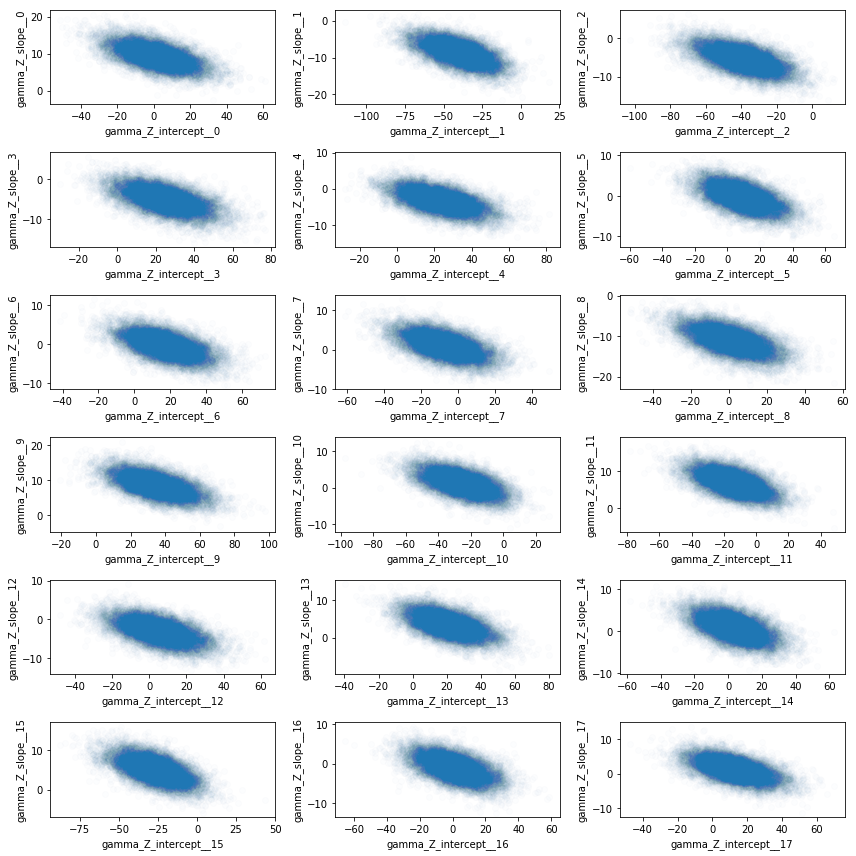

In [20]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12, 12))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    
plt.tight_layout()

## Posterior predictive check

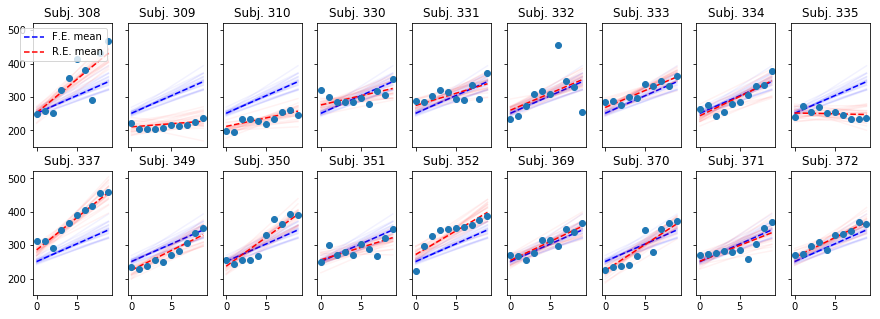

In [21]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

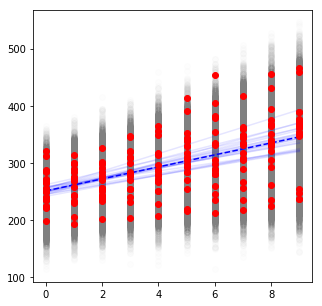

In [22]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [23]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1125.33it/s]


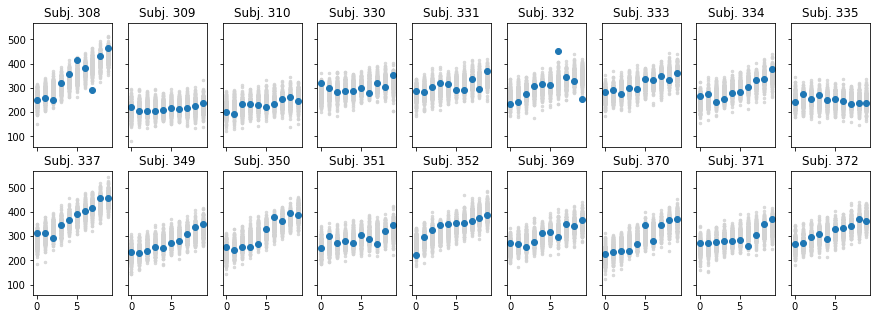

In [24]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))
